# Parte 1
Vamos a seguir los pasos indicados en https://realpython.com/generative-adversarial-networks

Para este punto vamos a asumir que ya se ha creado el ambiente de conda y se ha instalado pytorch 1.4.0.
Para hacerlo se pueden seguir los siguientes pasos:

```shell
conda create --name gan
conda activate gan
```

Una vez creado el ambiente de Conda, instalaremos las dependencias
```shell
conda install -c pytorch pytorch=1.4.0
conda install matplotlib jupyter
```

Por último, registraremos el ambiente recién creado para que el Jupyter lo pueda utilizar. Para eso utilizamos el siguiente comando:

```shell
python -m ipykernel install --user --name gan
```

Instalamos las librerías. También vamos a utilizar la semilla 111 para comparar que el resultado obtenido con respecto al tutorial sea el mísmo. Esta semilla no debe utilizarse en un ambiente de trabajo real a menos de que se desee eliminar la aleatoriedad introducida en el proceso.

In [1]:
import torch


import math
import matplotlib.pyplot as plt
from torch import nn

torch.manual_seed(111)


Preparamos la data de entrenamiento

In [2]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

El paso anterior crea una serie de 1024 pares ($X_1$, $X_2$). Luego, se crea la data de entrenamiento con un tensor de dimensiones de 1024 elementos con 2 columnas, todos conteniendo 0. En la línea 3 se utiliza la primera columna para almacenar valroes aleatorios en untervalos de 0 a 2$\pi$. en la cuarta línea se calcula la segunda columna del tensor como f(x) = $\sin(x)$ donde $x$ es el primer valor del tensor. Luego de esto, se require una lista de _categorías_, ya que es requerido por el dataloader de PyTorch. Pero debido a que los GANs utilizan tecnicas no supervisadas, estas etiquetas pueden ser lo que sea, ya que no serán utilizadas, por eso en la línea 5 se crean estas etiquetas llenas de ceros. En las lineas 6 a 8 se crea un train set como una lista de tuplas, cada una con una fila de train_data y train_labels representadas en cada tupla como las espera el data_loader de PyTorch. Podemos examinar la data haciendo un plot

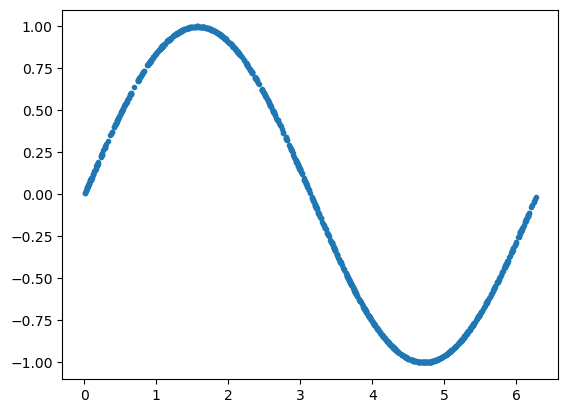

In [3]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

Ahora se puede crear un train loader utilizando el train_set

In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

## Implementando el Discriminador

La clase discriminator ha sido implementada en el archivo `Discriminator.py` para mantener más orden

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output
discriminator = Discriminator()

## Implementando el Generador
La clase generator ha sido implementada en el archivo `Generator.py` para mantener más orden

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output
generator = Generator()

## Entrenando los modelos

In [7]:
from torch import nn

lr = 0.0001
num_epochs = 5000
loss_function = nn.BCELoss()

In [8]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

## Ciclo de entrenamiento
Se implementa un ciclo de entrenamiento para que las muestras se alimenten a los modelos y los pesos se actualicen para minimizar la función de pérdida

In [9]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5937030911445618
Epoch: 0 Loss G.: 0.6508157849311829
Epoch: 10 Loss D.: 0.5032928586006165
Epoch: 10 Loss G.: 1.7843939065933228
Epoch: 20 Loss D.: 0.4679699242115021
Epoch: 20 Loss G.: 1.2406625747680664
Epoch: 30 Loss D.: 0.40113720297813416
Epoch: 30 Loss G.: 1.6917963027954102
Epoch: 40 Loss D.: 0.48328131437301636
Epoch: 40 Loss G.: 1.0925894975662231
Epoch: 50 Loss D.: 0.4455109238624573
Epoch: 50 Loss G.: 0.9658651947975159
Epoch: 60 Loss D.: 0.688954770565033
Epoch: 60 Loss G.: 1.0269949436187744
Epoch: 70 Loss D.: 0.627532422542572
Epoch: 70 Loss G.: 0.9174373149871826
Epoch: 80 Loss D.: 0.6108129620552063
Epoch: 80 Loss G.: 0.8526147603988647
Epoch: 90 Loss D.: 0.615460216999054
Epoch: 90 Loss G.: 0.9099251627922058
Epoch: 100 Loss D.: 0.5571238994598389
Epoch: 100 Loss G.: 0.8168425559997559
Epoch: 110 Loss D.: 0.636961817741394
Epoch: 110 Loss G.: 0.9569260478019714
Epoch: 120 Loss D.: 0.6036797761917114
Epoch: 120 Loss G.: 0.8155670166015625
Epoch: 130

# Revisión de muestras generadas por el GAN

In [10]:
latent_space_samples = torch.randn(100_000, 2)
generated_samples = generator(latent_space_samples)

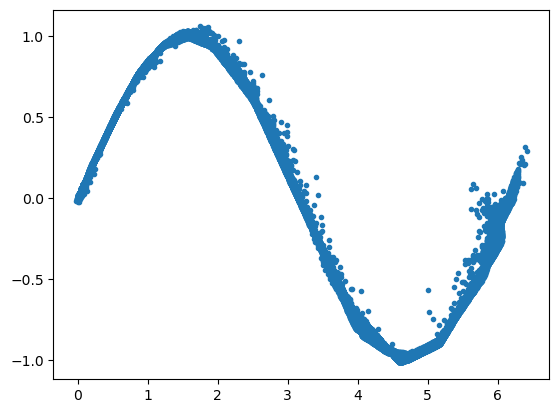

In [11]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")